In [64]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA

# The Data

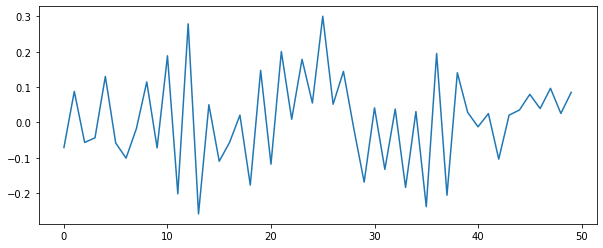

In [73]:
true_phi_1 = -0.2
true_phi_2 = 0.5
true_sigma = 0.1

xvals = [np.random.normal(0, true_sigma), np.random.normal(0, true_sigma)]
for _ in range(50):
    xvals.append(true_phi_1*xvals[-1] + true_phi_2*xvals[-2] + np.random.normal(0, true_sigma))
xvals = np.array(xvals[2:])
plt.figure(figsize=(10,4))
plt.plot(xvals)

# Usual Method : Fit AR Model

In [74]:
model = ARIMA(xvals, order=(2,0,0)).fit(maxiter=200)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:                     ARMA(2, 0)   Log Likelihood                  44.167
Method:                       css-mle   S.D. of innovations              0.099
Date:                Sun, 11 Apr 2021   AIC                            -80.335
Time:                        11:51:32   BIC                            -72.687
Sample:                             0   HQIC                           -77.422
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0097      0.019      0.511      0.609      -0.028       0.047
ar.L1.y       -0.2206      0.119     -1.855      0.064      -0.454       0.012
ar.L2.y        0.4975      0.119      4.176      0.000       0.264       0.731
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2133           +0.0000j            1.2133            0.5000
AR.2            1.6568           +0.0000j            1.6568            0.0000
-----------------------------------------------------------------------------
"""

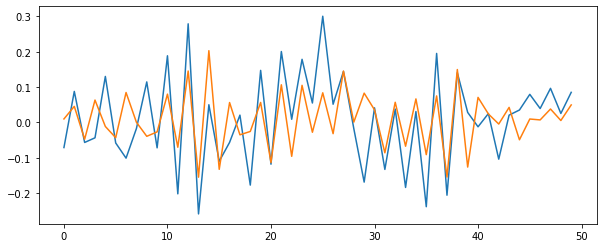

In [75]:
plt.figure(figsize=(10,4))
plt.plot(xvals)
plt.plot(model.fittedvalues)

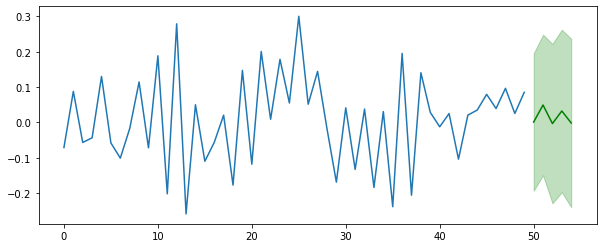

In [76]:
plt.figure(figsize=(10,4))
plt.plot(xvals)
forecast = model.forecast(5)
plt.plot(range(len(xvals), len(xvals) + 5), forecast[0], color='g')
plt.fill_between(range(len(xvals), len(xvals) + 5), forecast[2][:,0], forecast[2][:,1], color='g', alpha=0.25)

# Bayesian Analysis with PyMC3
***

# Priors:
## $\phi_1 \sim N(0,20)$
## $\phi_2 \sim N(0,20)$
## $\sigma \sim Exp(1)$
***

# Likelihood:
## $x_t|\phi_1, \phi_2, \sigma, x_{t-1}, x_{t-2} \sim N(\phi_1 x_{t-1} + \phi_2 x_{t-2}, \sigma)$
***

# Posterior
## $\phi_1, \phi_2, \sigma|x \sim ?$
***

C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # Remove the CWD from sys.path while we load stuff.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\ritvik\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\ritvik\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\ritvik\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sig

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 241 seconds.
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  del sys.path[0]
C:\Users\ritvik\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  


<Figure size 504x504 with 0 Axes>

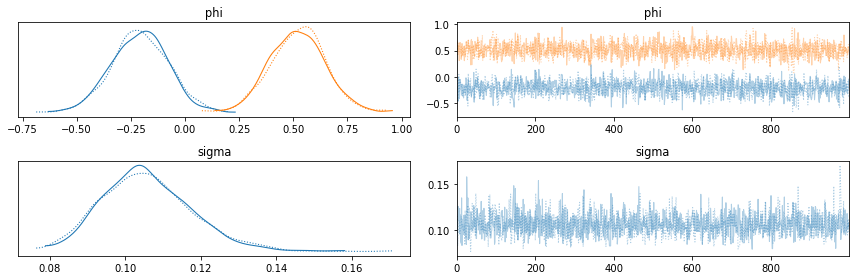

In [77]:
with pm.Model() as bayes_model:
    #priors
    phi = pm.Normal("phi", mu=0, sigma=20, shape=2)
    sigma = pm.Exponential("sigma", lam=1)

    #Likelihood
    likelihood = pm.AR("x", phi, sigma, observed=xvals)

    #posterior
    trace = pm.sample(1000, cores=2)
    
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout()

# Parameter Distributions

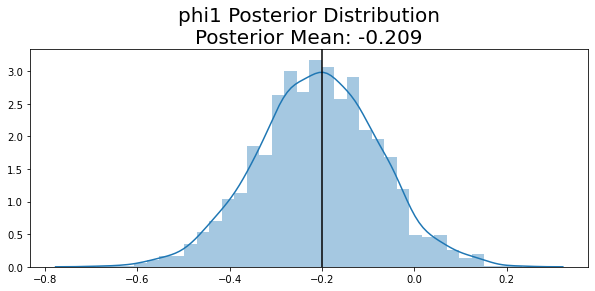

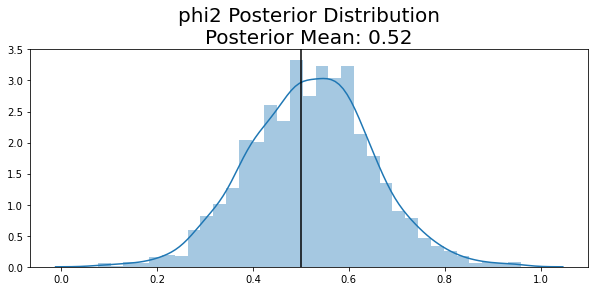

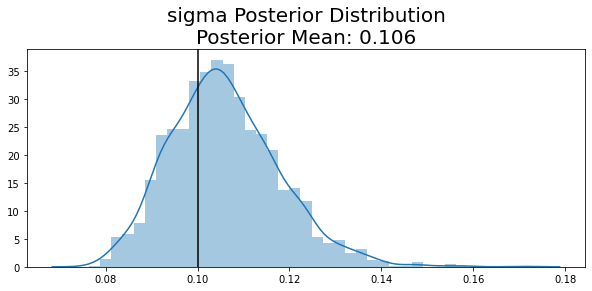

In [83]:
phi1_vals = trace.get_values('phi')[:,0]
phi2_vals = trace.get_values('phi')[:,1]
sigma_vals = trace.get_values('sigma')

plt.figure(figsize=(10,4))
sns.distplot(phi1_vals)
plt.axvline(true_phi_1, color='k')
plt.title('phi1 Posterior Distribution\nPosterior Mean: %s'%round(phi1_vals.mean(), 3), fontsize=20)
plt.show()

plt.figure(figsize=(10,4))
sns.distplot(phi2_vals)
plt.axvline(true_phi_2, color='k')
plt.title('phi2 Posterior Distribution\nPosterior Mean: %s'%round(phi2_vals.mean(), 3), fontsize=20)
plt.show()

plt.figure(figsize=(10,4))
sns.distplot(sigma_vals)
plt.axvline(true_sigma, color='k')
plt.title('sigma Posterior Distribution\nPosterior Mean: %s'%round(sigma_vals.mean(), 3), fontsize=20)
plt.show()

# Forecast Next Values

In [84]:
num_samples = 10000
forecasted_vals = []
num_periods = 5

for _ in range(num_samples):
    curr_vals = list(xvals.copy())
    
    phi1_val = np.random.choice(phi1_vals)
    phi2_val = np.random.choice(phi2_vals)
    sigma_val = np.random.choice(sigma_vals)
    
    for _ in range(num_periods):
        curr_vals.append(curr_vals[-1]*phi1_val + curr_vals[-2]*phi2_val + np.random.normal(0, sigma_val))
    forecasted_vals.append(curr_vals[-num_periods:]) 
forecasted_vals = np.array(forecasted_vals)

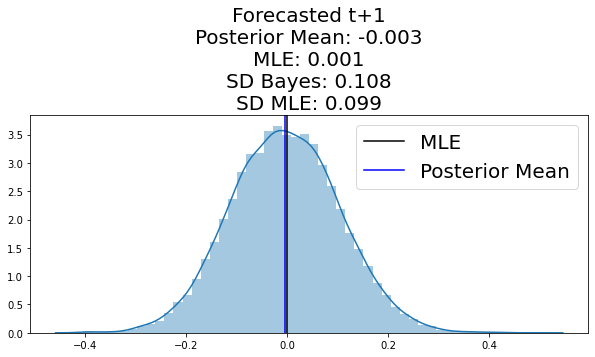

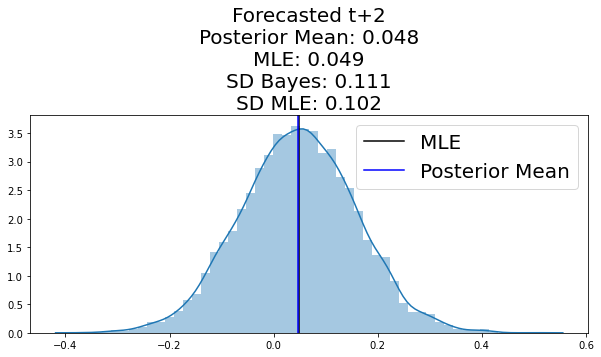

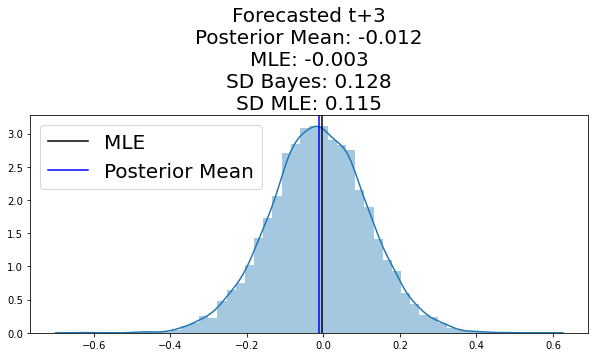

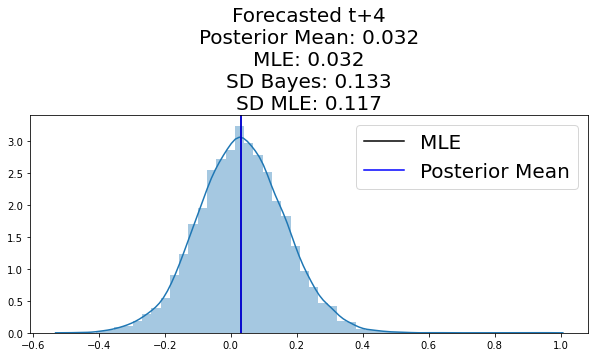

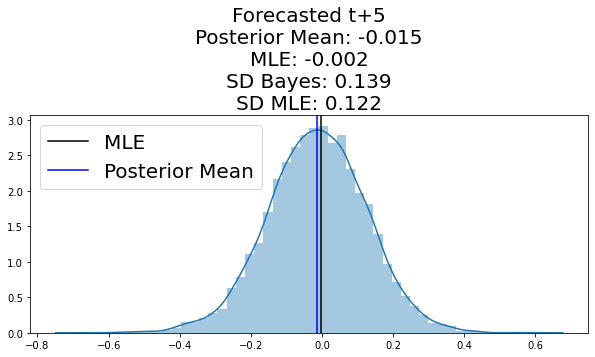

In [86]:
for i in range(num_periods):
    plt.figure(figsize=(10,4))
    vals = forecasted_vals[:,i]
    mu, dev = round(vals.mean(), 3), round(vals.std(), 3)
    sns.distplot(vals)
    p1 = plt.axvline(forecast[0][i], color='k')
    p2 = plt.axvline(vals.mean(), color='b')
    plt.legend((p1,p2), ('MLE', 'Posterior Mean'), fontsize=20)
    plt.title('Forecasted t+%s\nPosterior Mean: %s\nMLE: %s\nSD Bayes: %s\nSD MLE: %s'%((i+1), mu, round(forecast[0][i],3), dev, round(forecast[1][i],3)), fontsize=20)